# 빅데이터프로그래밍
       
       
12주 1강: Dask
<br/><br/>

숭실대학교<br/>
AI융합학부<br/>
윤진혁<br/>

# Today
- Dask란 무엇인가
- Dask를 통한 Lazy execution
- dask.bag
- dask.array
- dask.dataframe

1. 오늘의 강의는 dask의 official tutorial에 기반합니다 (http://github.com/dask/dask-tutorial)

2. 오늘 강의를 직접 해 보시려면 `binder`폴더 안의 `environment.yml`을 통해 새 가상환경을 먼저 구성하셔야 합니다.

```bash
conda env create -f binder/environment.yml
conda activate dask-tutorial
jupyter labextension install @jupyter-widgets/jupyterlab-manager
jupyter labextension install @bokeh/jupyter_bokeh
```    

* jupyter의 kernel을 설치하려면 아래의 command를 새 가상환경에서 실행하시면 됩니다.
```bash
python -m ipykernel install --user --name <원하는 커널 이름>
```

# Parallelize code with `dask.delayed`
Dask는 기본적으로 scale out을 위한 다양한 기능을 제공합니다. 가장 많이 쓰는 기능은 Pandas와 유사한 dataframe의 병렬화/가상화지만, 그 전에 dask의 원리를 조금 이해해봅시다. 지난 시간에 RDD의 장점 중 하나로 DAG를 이용한 Lazy (delayed) execution를 소개했습니다. 이와 유사하게 `dask.dealyed`를 통해서 lazy execution을 구현해 봅시다. Python의 다른 함수나 기능을 dask와 함께 사용하게 해주는 함수입니다. 

Dask는 이 방법 이외에도 코드를 병렬화해서 실행 가능한 방법이 많습니다. 일단은 distributed scheduler (`dask.distributed.Client`)를 통해서 병렬화를 해 봅시다. 이 스케쥴러에 대한 자세한 설명은 추후에 다루겠습니다.

In [1]:
from dask.distributed import Client

client = Client(n_workers=4)

## Basics
`inc` and `add`라는 간단한 함수를 만들어 봅시다. 

In [2]:
from time import sleep

def inc(x):
    sleep(1)
    return x + 1

def add(x, y):
    sleep(1)
    return x + y

이 함수들의 실행 시간을 체크해봅시다. 아래의 3단계 계산을 해 봅시다. 시간을 재는 것은 `%%time` magic commnnd를 쓰면 됩니다. 의도적으로 1초의 딜레이를 주었기 때문에, 3초가 조금 넘는 시간이 걸립니다.

In [3]:
%%time
x = inc(1)
y = inc(2)
z = add(x, y)

Wall time: 3.04 s


### Parallelize with the `dask.delayed` decorator

위의 두 함수는 서로 독립적으로 실행이 됩니다. 즉 병렬화 할 수 있습니다. 

그럼 이 함수들을 `dask.delayed` function으로 병렬화 해 봅시다. 쓰는 방법은 단순합니다. 아래처럼 함수를 delayed decorator로 감싸주고, arguments들을 넘겨주면 됩니다. 

하지만 이 시점에서 함수들은 실행되지 않습니다. 대신 함수 실행 기록을 가지고 있는 *delayed object*라는 것이 만들어집니다.

In [4]:
from dask import delayed

In [5]:
%%time
# This runs immediately, all it does is build a graph
x = delayed(inc)(1)
y = delayed(inc)(2)
z = delayed(add)(x, y)

Wall time: 1 ms


아무 함수도 실제로는 실행되지 않았으므로 실행 시간은 0 ns입니다. 

이것을 실제로 계산하려면 `compute` method를 사용하면 됩니다. 

In [6]:
%%time
z.compute()

Wall time: 2.03 s


5

## What just happened?

여기서 `z` 오브젝트는 lazy execution이 가능한 delayed object입니다. 이 object는 최종 결과를 내기 위해 필요한 중간 단계들이 무엇이 필요한지를 가지고 있습니다. 예를 들어서 어떤 함수가 실행되는지, 그리고 각 함수간의 의존성은 어떻게 되는지 등을 확인해서 그 결과를 가지고 있습니다. 그리고 최종적으로 이 함수들을 `.compute` 메소드를 통해서 실행하게 됩니다. 이 과정을 `visualize`를 통해서 그래프 형태로 확인할 수 있습니다.

In [7]:
z

Delayed('add-39036c96-fe27-469b-b7fb-902953686477')

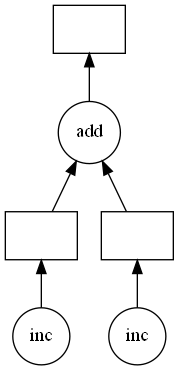

In [8]:
# z에 대한 task graph를 살펴봅시다
# 만약 제대로 실행이 되지 않는다면, graphviz를 설치해 주시고 (https://graphviz.org/) anaconda의 graphviz package위치를 path에 추가해 주셔야 합니다.
z.visualize()

이 그래프에서 두 `inc`함수의 실행 결과가 `add`의 인자로 쓰인다는 것을 알 수 있습니다. 

## Exercise: Parallelize a for loop
Python에서 for loop는 매우 느립니다. 그래서 for loop를 병렬화 하는 것은 자주 사용하는 성능 향상 기법입니다. 일반적으로 python의 multiprocessing의 모듈들을 사용할 수 있지만, dask는 lazy execution을 통해 훨씬 쉽게 병렬화를 시켜줍니다. 

In [9]:
data = [1, 2, 3, 4, 5, 6, 7, 8]

In [11]:
%%time
results = []
for x in data:
    y = inc(x)
    results.append(y)
    
total = sum(results)

Wall time: 8.05 s


In [12]:
total

44

In [13]:
%%time
results = []

for x in data:
    y = delayed(inc)(x)
    results.append(y)
    
total = delayed(sum)(results)
print("Before computing:", total)  # total의 타입은 무엇일까요.
result = total.compute()
print("After computing :", result) 

Before computing: Delayed('sum-c9af0025-5166-47cc-a034-9ddc8324bd44')
After computing : 44
Wall time: 1.04 s


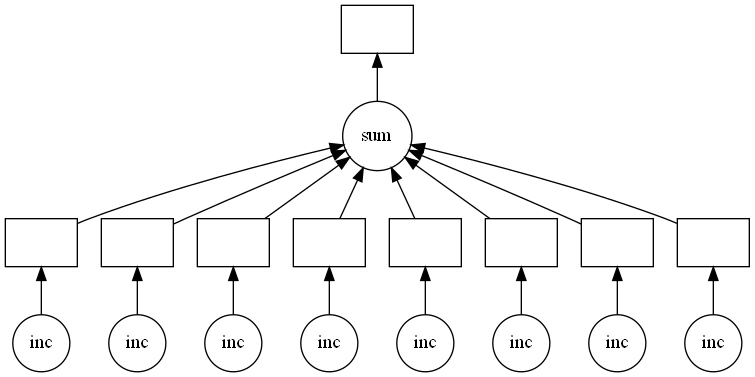

In [14]:
total.visualize()

## Exercise: Parallelizing a for-loop code with control flow

간혹 이런 경우가 있습니다. 몇몇 경우는 바로 실행해야 되고, 몇몇 경우는 병렬화가 되고, 어떤 함수는 lazy execution이 가능하고 어떤 경우는 불가능하고. dask.delayed는 이런 경우들을 매우 잘 처리해줍니다. 

아래와 같은 경우를 생각해보죠. 홀수와 짝수인 경우에 다른 함수를 실행한다고 생각해 봅시다. is_even은 inc와 double중 하나의 함수를 실행할지를 결정하기 위해서 먼저 즉시 실행되어야 합니다. 이 경우는 어떻게 처리될까요?

In [15]:
def double(x):
    sleep(1)
    return 2 * x

def is_even(x):
    return not x % 2

data = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]

In [16]:
%%time
results = []
for x in data:
    if is_even(x):
        y = double(x)
    else:
        y = inc(x)
    results.append(y)
    
total = sum(results)
print(total)

90
Wall time: 10.1 s


In [17]:
%%time
results = []
for x in data:
    if is_even(x):  # even
        y = delayed(double)(x)
    else:          # odd
        y = delayed(inc)(x)
    results.append(y)
    
total = delayed(sum)(results) # 이 단계에서 is_even은 이미 실행이 됩니다. 그래서 0ms가 아니라 "아주 약간의" 실행시간이 필요합니다.

Wall time: 0 ns


In [18]:
%time total.compute()

Wall time: 1.03 s


90

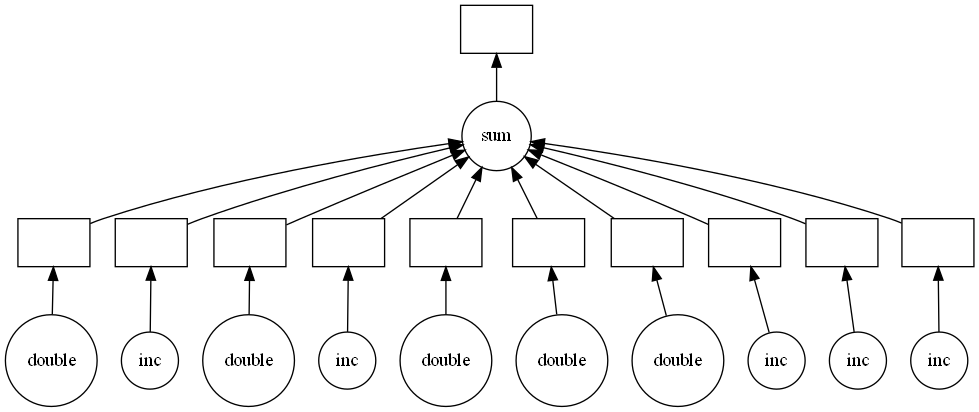

In [19]:
total.visualize()

## Parallelizing a Pandas Groupby Reduction

이번에는 pandas를 병렬화 해 보겠습니다. 사실 뒤에 dataframe의 직접적인 병렬화를 배우지만, 여기서는 단순하게 dask.delayed 와 pandas를 통해서 해 봅시다. 몇 개의 csv파일을 읽고 groupby를 병렬화해서 수행해 보겠습니다.

## Create data
1990년부터 2000년 사이의 뉴욕시 비행 데이터를 사용해 봅시다. 원본 데이터는 [여기](http://stat-computing.org/dataexpo/2009/the-data.html)에서 받을 수 있습니다.

In [20]:
# 아래 코드를 실행시키면 data/nycflights 폴더에 데이터 파일이 다운받아집니다.
%run prep.py -d flights

### Inspect data

In [21]:
import os
sorted(os.listdir(os.path.join('data', 'nycflights')))
# 연도별 데이터를 받았네요

['1990.csv',
 '1991.csv',
 '1992.csv',
 '1993.csv',
 '1994.csv',
 '1995.csv',
 '1996.csv',
 '1997.csv',
 '1998.csv',
 '1999.csv']

### Read one file with `pandas.read_csv` and compute mean departure delay

In [22]:
# 파일 하나를 읽고 평균 출발 지연 시간을 구해보겠습니다.
import pandas as pd
df = pd.read_csv(os.path.join('data', 'nycflights', '1990.csv'))
df.head()

,Year,Month,DayofMonth,DayOfWeek,DepTime,CRSDepTime,ArrTime,CRSArrTime,UniqueCarrier,FlightNum,...,AirTime,ArrDelay,DepDelay,Origin,Dest,Distance,TaxiIn,TaxiOut,Cancelled,Diverted
0,1990,1,1,1,1621.0,1540,1747.0,1701,US,33,...,NaN,46.0,41.0,EWR,PIT,319.0,NaN,NaN,0,0
1,1990,1,2,2,1547.0,1540,1700.0,1701,US,33,...,NaN,-1.0,7.0,EWR,PIT,319.0,NaN,NaN,0,0
2,1990,1,3,3,1546.0,1540,1710.0,1701,US,33,...,NaN,9.0,6.0,EWR,PIT,319.0,NaN,NaN,0,0
3,1990,1,4,4,1542.0,1540,1710.0,1701,US,33,...,NaN,9.0,2.0,EWR,PIT,319.0,NaN,NaN,0,0
4,1990,1,5,5,1549.0,1540,1706.0,1701,US,33,...,NaN,5.0,9.0,EWR,PIT,319.0,NaN,NaN,0,0


In [23]:
# What is the schema?
df.dtypes

Year                   int64
Month                  int64
DayofMonth             int64
DayOfWeek              int64
DepTime              float64
CRSDepTime             int64
ArrTime              float64
CRSArrTime             int64
UniqueCarrier         object
FlightNum              int64
TailNum              float64
ActualElapsedTime    float64
CRSElapsedTime         int64
AirTime              float64
ArrDelay             float64
DepDelay             float64
Origin                object
Dest                  object
Distance             float64
TaxiIn               float64
TaxiOut              float64
Cancelled              int64
Diverted               int64
dtype: object

In [24]:
# 뉴욕에 공항이 3개가 있습니다. 유명한 JFK 말고도, 라과디아 공항(LGA)과 뉴어크 리버티 국제공항이 있습니다(EWA).
df.Origin.unique()

array(['EWR', 'LGA', 'JFK'], dtype=object)

In [25]:
# 1990년의 비행 딜레이를 공항 별로 구해봅시다. JFK가 가장 딜레이가 깁니다.
df.groupby('Origin').DepDelay.mean()

Origin
EWR     9.168411
JFK    11.857274
LGA     8.560045
Name: DepDelay, dtype: float64

### Sequential code: Mean Departure Delay Per Airport

이제 for loop를 통해 순차적으로 전체 연도의 딜레이를 구해봅시다.

In [26]:
from glob import glob
filenames = sorted(glob(os.path.join('data', 'nycflights', '*.csv')))

In [27]:
%%time

sums = []
counts = []
for fn in filenames:
    # Read in file
    df = pd.read_csv(fn) 
    # Groupby origin airport
    by_origin = df.groupby('Origin')    
    # Sum of all departure delays by origin
    total = by_origin.DepDelay.sum()    
    # Number of flights by origin
    count = by_origin.DepDelay.count()
    # Save the intermediates
    sums.append(total)
    counts.append(count)

# Combine intermediates to get total mean-delay-per-origin
total_delays = sum(sums)
n_flights = sum(counts)
mean = total_delays / n_flights

Wall time: 3.3 s


In [28]:
mean

Origin
EWR    10.295469
JFK    10.351299
LGA     7.431142
Name: DepDelay, dtype: float64

### Parallelize the code above

이제 `dask.delayed` 를 통해서 병렬화를 해 봅시다. 몇가지 delayed execution에 대해서 알아두어야 할 것들이 더 있습니다.

1. delayed object는 슬라이싱, 사칙연산, method call을 할 수 있습니다.  

    ```python
    x = delayed(np.arange)(10)
    y = (x + 1)[::2].sum()  # everything here was delayed
    ```

    
2. .compute()는 output이 한 개 일때는 잘 작동합니다. 그렇지 않을 떄는 dask.compute함수를 사용하면 됩니다. 

    ```python
    >>> from dask import compute
    >>> x = delayed(np.arange)(10)
    >>> y = x ** 2
    >>> min_, max_ = compute(y.min(), y.max())
    >>> min_, max_
    (0, 81)
    ```
    
    이 때 dask는 중간 계산값을 compute 안의 계산들에서 서로 공유합니다 (예를 들자면 `y = x**2` 같은 것이죠).

In [29]:
%%time
from dask import compute
sums = []
counts = []
for fn in filenames:
    # Read in file
    df = delayed(pd.read_csv)(fn)

    # Groupby origin airport
    by_origin = df.groupby('Origin')

    # Sum of all departure delays by origin
    total = by_origin.DepDelay.sum()

    # Number of flights by origin
    count = by_origin.DepDelay.count()

    # Save the intermediates
    sums.append(total)
    counts.append(count)

# Compute the intermediates
sums, counts = compute(sums, counts)

# Combine intermediates to get total mean-delay-per-origin
total_delays = sum(sums)
n_flights = sum(counts)
mean = total_delays / n_flights

Wall time: 925 ms


In [30]:
# ensure the results still match
mean

Origin
EWR    10.295469
JFK    10.351299
LGA     7.431142
Name: DepDelay, dtype: float64

## Close the Client
계산을 마친 이후에는 client를 닫아 주어야 안전합니다.

In [31]:
client.close()

## Dask is a graph execution engine

Dask는 수행하려는 계산의 순서도를 DAG로 그려줍니다. 즉, 결과를 내기 위해 단계별로 필요한 계산들의 순서도를 만들어 줍니다. 위의 for loop의 예를 다시 돌아와 봅시다. 

In [33]:
from dask import delayed

@delayed #이런 식으로 delayed execution이 가능하게 표시해줄 수 있습니다. 
def inc(x):
    return x + 1

@delayed
def add(x, y):
    return x + y

In [34]:
# 평범한 함수 같지만, 위의 경우도 delayed execution이 가능해집니다.
x = inc(15)
y = inc(30)
total = add(x, y)

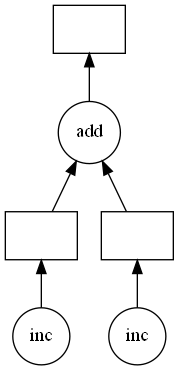

In [35]:
total.visualize()

이 단계까지는 아무런 계산이 수행되지 않습니다. compute를 통해 계산을 수행하라고 명령해야 계산이 수행됩니다.

In [36]:
# execute all tasks
total.compute()

47

**Why should you care about this?**
단순한 for문에서는 왜 이런 것이 필요한지 알기 힘들 수 있습니다. 하지만 아래의 그림의 예처럼, 복잡한 순서도가 있고 많은 컴퓨터로 이루어진 클러스터가 있다고 생각해 봅시다. 그렇다면 "어떤 계산을 먼저 수행하냐"를 정하는 것이 자원을 배분하는데 가장 중요한 역할이 됩니다. 예를 들어서 늦게 계산해야 할 것을 할당받은 컴퓨터는 그 이전 계산이 수행되기 전 까지는 아무런 역할을 하지 못합니다! 이는 큰 낭비지요.

![this](Figs/grid_search_schedule.gif)

# Bag: Parallel Lists for semi-structured data

Dask는 RAM보다 큰 데이터를 저장할 수있는 3 개의 병렬 처리 방식이 있습니다. Dataframes, Bags, Arrays입니다. 이러한 각 유형은 RAM과 하드 디스크간에 분할 된 데이터를 사용할 수 있을 뿐만 아니라 클러스터의 여러 노드에 분산해서 처리도 가능합니다. 

Dask Bag은 메모리에 맞지 않는 임으의 Python object 컬렉션을 저장하고 처리 할 수 있습니다. Dask Bag은 로그 및 json 문서를 처리하는 데 적합합니다. 우리가 big data를 다루는 경우 많은 상황에서 json 데이터를 만나게 됩니다. 이외에도 csv, xml등의 데이터, 그리고 python의 데이터타입과 일치하지 않는 모든 데이터를 처리하는데 적절합니다. 이러한 것들을 python은 list, dict, set 등을 통해 주로 다룹니다만, dask-bag은 훨씬 효율적으로 처리해 줍니다. 

쉽게 정리하면 dask bag은 map, filter, toolz + parallel execution이 가능한 dask의 기능 collection 중 하나입니다.

다시 한 번 scheduler를 실행해 봅시다. 

In [37]:
from dask.distributed import Client

client = Client(n_workers=4)

## Creation

일단 'bag' object는 python sequecne, local file, 그리고 클라우드 (예를 들어서 amazon S3라던지)등을 통해 만들 수 있습니다.
`.take()`함수는 각 data의 element를 조회해 줍니다. `.take(n)`은 처음부터 n개의 데이터를 조회해 줍니다. 

이 데이터들은 블록으로 나누어져 있고, 각 블록마다 여러개의 아이템으로 구성되어 있습니다. 예를 들어서 처음 example은 npartitions=2 를 통해서 5개의 elements를 가진 2개의 파티션으로 구성되어 있다는 것을 알 수 있습니다.

In [38]:
# each element is an integer
import dask.bag as db
b = db.from_sequence([1, 2, 3, 4, 5, 6, 7, 8, 9, 10], npartitions=2)
b.take(3)

(1, 2, 3)

In [39]:
%run prep.py -d accounts
# 데이터를 다운받았습니다.
# each element is a text file, where each line is a JSON object
# gzip 파일의 압축 해제가 자동으로 이루어지는 것도 확인해 주세요.
import os
b = db.read_text(os.path.join('data', 'accounts.*.json.gz'))
b.take(1)

('{"id": 0, "name": "Victor", "transactions": [{"transaction-id": 43, "amount": -1088}, {"transaction-id": 614, "amount": -1045}, {"transaction-id": 654, "amount": -1197}, {"transaction-id": 1099, "amount": -1067}, {"transaction-id": 1184, "amount": -924}, {"transaction-id": 1404, "amount": -1027}, {"transaction-id": 1552, "amount": -1108}, {"transaction-id": 2087, "amount": -1098}, {"transaction-id": 2362, "amount": -1108}, {"transaction-id": 2449, "amount": -1067}, {"transaction-id": 2570, "amount": -1127}, {"transaction-id": 3463, "amount": -1139}, {"transaction-id": 4400, "amount": -972}, {"transaction-id": 4589, "amount": -958}, {"transaction-id": 4700, "amount": -1199}, {"transaction-id": 4986, "amount": -1180}, {"transaction-id": 5095, "amount": -1166}, {"transaction-id": 5417, "amount": -1121}, {"transaction-id": 5884, "amount": -1047}, {"transaction-id": 6739, "amount": -1059}, {"transaction-id": 7517, "amount": -1080}, {"transaction-id": 7967, "amount": -1062}, {"transaction-

In [41]:
# sources.py에 있는 s3주소를 변경하면 아래의 주소가 바뀝니다.
# 어쨌꺼나 s3 클라우드에 있는 파일도 바로 불러올 수 있습니다.
import sources
sources.bag_url

's3://dask-data/nyc-taxi/2015/yellow_tripdata_2015-01.csv'

In [42]:
# `s3fs` library를 설치해야 데이터 확인을 할 수 있습니다. 
# 아래와 같은 경우 각 partition은 한 개의 csv파일을 의미합니다. 지금은 파일이 한 개네요.
b = db.read_text(sources.bag_url,
                 storage_options={'anon': True})
b.take(1)

('VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,pickup_longitude,pickup_latitude,RateCodeID,store_and_fwd_flag,dropoff_longitude,dropoff_latitude,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount\n',)

## Manipulation
저희가 spark을 배우진 않았지만, `Bag`의 사용방법은 `pyspark`과 매우 유사합니다. `map`, `filter`, `groupby`, 등의 method를 사용할 수 있습니다. 
`Bag` object에 계산을 수행하면 또 다른 `Bag` object가 만들어집니다. 위의 delayed execution과 같이 `.compute()`를 통해 실행하면 됩니다.

In [44]:
def is_even(n):
    return n % 2 == 0

b = db.from_sequence([1, 2, 3, 4, 5, 6, 7, 8, 9, 10])
c = b.filter(is_even).map(lambda x: x ** 2)
# lambda 함수는 별도로 설명은 안드리겠습니다. 하지만 x를 넣으면 x**2이 리턴되는 함수와 같은 역할을 합니다.
c

dask.bag<lambda, npartitions=10>

In [45]:
# blocking form: wait for completion (which is very fast in this case)
c.compute()

[4, 16, 36, 64, 100]

### Example: Accounts JSON data

In [46]:
# 일단 데이터를 다운받읍시다
%run prep.py -d accounts

위에서 받은 Json은 `data/accounts.*.json.gz`에 있습니다. 각 줄은 아래의 3가지 사항을 가지고 있습니다. 

*  id: 손님의 id
*  name: 손님의 이름
*  transactions: `transaction-id`와 `amount`의 pair들. 이 손님의 송금 내역.

In [50]:
# 일단 데이터를 읽어옵시다.
filename = os.path.join('data', 'accounts.*.json.gz')
lines = db.read_text(filename)
#lines.take(1)

map을 사용해서 json.load를 통해 조금 더 읽기 편한 json형태로 읽어옵시다.

In [51]:
import json
js = lines.map(json.loads) 
# take: inspect first few elements
js.take(3)

({'id': 0,
  'name': 'Victor',
  'transactions': [{'transaction-id': 43, 'amount': -1088},
   {'transaction-id': 614, 'amount': -1045},
   {'transaction-id': 654, 'amount': -1197},
   {'transaction-id': 1099, 'amount': -1067},
   {'transaction-id': 1184, 'amount': -924},
   {'transaction-id': 1404, 'amount': -1027},
   {'transaction-id': 1552, 'amount': -1108},
   {'transaction-id': 2087, 'amount': -1098},
   {'transaction-id': 2362, 'amount': -1108},
   {'transaction-id': 2449, 'amount': -1067},
   {'transaction-id': 2570, 'amount': -1127},
   {'transaction-id': 3463, 'amount': -1139},
   {'transaction-id': 4400, 'amount': -972},
   {'transaction-id': 4589, 'amount': -958},
   {'transaction-id': 4700, 'amount': -1199},
   {'transaction-id': 4986, 'amount': -1180},
   {'transaction-id': 5095, 'amount': -1166},
   {'transaction-id': 5417, 'amount': -1121},
   {'transaction-id': 5884, 'amount': -1047},
   {'transaction-id': 6739, 'amount': -1059},
   {'transaction-id': 7517, 'amount': -1

### Basic Queries

JSON 데이터를 적절한 Python 객체 (`dict`s,`list`s 등)로 변환하면 Python 함수를 통해 더 복잡한 작업을 수행할 수 있습니다.

In [52]:
# filter: 전체에서 일부 element만 남기는 것을 수행해 줍니다. 아래의 예는 이름이 Alice인 데이터만 남겨줍니다.
js.filter(lambda record: record['name'] == 'Alice').take(5)

({'id': 30,
  'name': 'Alice',
  'transactions': [{'transaction-id': 8, 'amount': 46},
   {'transaction-id': 674, 'amount': 77},
   {'transaction-id': 944, 'amount': 58},
   {'transaction-id': 1442, 'amount': 65},
   {'transaction-id': 1960, 'amount': 59},
   {'transaction-id': 2154, 'amount': 65},
   {'transaction-id': 2487, 'amount': 68},
   {'transaction-id': 4153, 'amount': 59},
   {'transaction-id': 4161, 'amount': 76},
   {'transaction-id': 5902, 'amount': 74},
   {'transaction-id': 5921, 'amount': 63},
   {'transaction-id': 6416, 'amount': 57},
   {'transaction-id': 7497, 'amount': 68},
   {'transaction-id': 8187, 'amount': 70},
   {'transaction-id': 8455, 'amount': 59},
   {'transaction-id': 8853, 'amount': 73},
   {'transaction-id': 10643, 'amount': 66},
   {'transaction-id': 12582, 'amount': 60},
   {'transaction-id': 13752, 'amount': 62},
   {'transaction-id': 14258, 'amount': 62},
   {'transaction-id': 14444, 'amount': 83},
   {'transaction-id': 15046, 'amount': 60},
   {'t

In [53]:
def count_transactions(d):
    return {'name': d['name'], 'count': len(d['transactions'])}

# map: 각 element에 함수를 적용해 줍니다.
(js.filter(lambda record: record['name'] == 'Alice') 
   .map(count_transactions)
   .take(5))

({'name': 'Alice', 'count': 165},
 {'name': 'Alice', 'count': 524},
 {'name': 'Alice', 'count': 36},
 {'name': 'Alice', 'count': 678},
 {'name': 'Alice', 'count': 662})

In [54]:
# pluck: 특정 field를 선택하게 해 줍니다. 
(js.filter(lambda record: record['name'] == 'Alice')
   .map(count_transactions)
   .pluck('count')
   .take(5))

(165, 524, 36, 678, 662)

In [55]:
# Alice들의 평균 송금 수를 확인해 봅시다.
(js.filter(lambda record: record['name'] == 'Alice')
   .map(count_transactions)
   .pluck('count')
   .mean()
   .compute())

227.35684210526315

### Use `flatten` to de-nest

`.flatten()`을 사용해서 데이터를 flatten 해 봅시다.

In [56]:
(js.filter(lambda record: record['name'] == 'Alice')
   .pluck('transactions')
   .take(3))[0][0:10]

[{'transaction-id': 8, 'amount': 46},
 {'transaction-id': 674, 'amount': 77},
 {'transaction-id': 944, 'amount': 58},
 {'transaction-id': 1442, 'amount': 65},
 {'transaction-id': 1960, 'amount': 59},
 {'transaction-id': 2154, 'amount': 65},
 {'transaction-id': 2487, 'amount': 68},
 {'transaction-id': 4153, 'amount': 59},
 {'transaction-id': 4161, 'amount': 76},
 {'transaction-id': 5902, 'amount': 74}]

In [57]:
(js.filter(lambda record: record['name'] == 'Alice')
   .pluck('transactions')
   .flatten()
   .take(3))

({'transaction-id': 8, 'amount': 46},
 {'transaction-id': 674, 'amount': 77},
 {'transaction-id': 944, 'amount': 58})

In [59]:
(js.filter(lambda record: record['name'] == 'Alice')
   .pluck('transactions')
   .flatten()
   .pluck('amount')
   .take(3))

(46, 77, 58)

In [60]:
(js.filter(lambda record: record['name'] == 'Alice')
   .pluck('transactions')
   .flatten()
   .pluck('amount')
   .mean()
   .compute())

2105.6833959136807

### Groupby and Foldby

Pandas dataframe 강의에서도 배웠듯, 실제 데이터를 다루는데 가장 많이 쓰는 기법중 하나는 `groupby`입니다. 이 방법은 직관적이지만 전체 데이터에서 같은 key값을 가진 것들을 모아야 하므로, key값을 통한 정렬이 필요하고, 이 과정은 꽤 느립니다. dask는 조금 더 사용이 복잡하지만 빠른 `.foldby`라는 method가 있습니다. 이것은 작은 단위 데이터를 groupby을 수행 후에 reduction을 수행합니다 (map-reduce 컨셉 기억하시죠?)

*  `groupby`: 동일한 키를 가진 모든 항목이 동일한 키-값 쌍에 있도록 데이터를 섞습니다.
*  `foldby`: 키당 결과를 누적시켜 최종 데이터를 구합니다.

### `groupby`

Groupby는 동일한 키값을 가진 모든 항목이 키-값 쌍으로 함께 위치하도록 섞은 뒤 계산합니다.

In [61]:
b = db.from_sequence(['Alice', 'Bob', 'Charlie', 'Dan', 'Edith', 'Frank'])
b.groupby(len).compute()  # names grouped by length

[(7, ['Charlie']), (3, ['Bob', 'Dan']), (5, ['Alice', 'Edith', 'Frank'])]

In [62]:
b = db.from_sequence(list(range(10)))
b.groupby(lambda x: x % 2).compute()

[(0, [0, 2, 4, 6, 8]), (1, [1, 3, 5, 7, 9])]

In [63]:
b.groupby(lambda x: x % 2).starmap(lambda k, v: (k, max(v))).compute()

[(0, 8), (1, 9)]

### `foldby`

Foldby의 컨셉은 처음에는 이해하기 어려울 수 있습니다. 비슷한 concept으로 pyspark와 toolz의 아래 함수들이 있습니다.:

*  [`toolz.reduceby`](http://toolz.readthedocs.io/en/latest/streaming-analytics.html#streaming-split-apply-combine)
*  [`pyspark.RDD.combineByKey`](http://abshinn.github.io/python/apache-spark/2014/10/11/using-combinebykey-in-apache-spark/)

foldby를 사용할 때는 아래와 같은 것들을 인자로 넣어주어야 합니다.

1. 요소를 그룹화하는 키값, 혹은 키값의 생성 함수
2. reduce 방법 (최대값, 최소값 등등): binop
3. 이렇게 reduce한 결과들을 합치는 결합 연산자: combine

In [64]:
# 위와 동일한 연산을 foldby로 수행해 봅시다.
b.foldby(lambda x: x % 2, binop=max, combine=max).compute()

[(0, 8), (1, 9)]

### Example with account data

같은 이름을 가진 사람의 수를 세 보는 일을 하겠습니다.

In [65]:
%%time
# 먼저 groupby로 해 봅시다. 시간이 좀 걸립니다.
result = js.groupby(lambda item: item['name'], shuffle='disk', npartitions=1).starmap(lambda k, v: (k, len(v))).compute()
print(sorted(result))

[('Alice', 950), ('Bob', 850), ('Charlie', 1150), ('Dan', 1200), ('Edith', 1049), ('Frank', 800), ('George', 1050), ('Hannah', 1050), ('Ingrid', 700), ('Jerry', 850), ('Kevin', 900), ('Laura', 850), ('Michael', 900), ('Norbert', 800), ('Oliver', 1000), ('Patricia', 950), ('Quinn', 797), ('Ray', 1198), ('Sarah', 896), ('Tim', 748), ('Ursula', 750), ('Victor', 950), ('Wendy', 1048), ('Xavier', 1250), ('Yvonne', 968), ('Zelda', 1277)]
Wall time: 5.82 s


In [66]:
%%time
# foldby로 동일 연산을 수행해 봅시다
from operator import add
def incr(tot, _):
    return tot + 1

result = js.foldby(key='name', 
                   binop=incr, 
                   initial=0, 
                   combine=add, 
                   combine_initial=0).compute()
print(sorted(result))

[('Alice', 950), ('Bob', 850), ('Charlie', 1150), ('Dan', 1200), ('Edith', 1049), ('Frank', 800), ('George', 1050), ('Hannah', 1050), ('Ingrid', 700), ('Jerry', 850), ('Kevin', 900), ('Laura', 850), ('Michael', 900), ('Norbert', 800), ('Oliver', 1000), ('Patricia', 950), ('Quinn', 797), ('Ray', 1198), ('Sarah', 896), ('Tim', 748), ('Ursula', 750), ('Victor', 950), ('Wendy', 1048), ('Xavier', 1250), ('Yvonne', 968), ('Zelda', 1277)]
Wall time: 1.56 s


## DataFrames

Pandas DataFrame이 Python의 object들보다 보통 빠르게 작동하는 것 처럼, dask의 dataframe은 보통 bag보다 빠릅니다. DataFrame에 대한 자세한 내용은 아래에서 배우기로 하고, bag을 dask.dataframe으로 바꾸어서 위와 유사한 groupby를 수행해 봅시다. 

In [67]:
df1 = js.to_dataframe()
df1.head()

,id,name,transactions
0,0,Victor,"[{'transaction-id': 43, 'amount': -1088}, {'tr..."
1,1,Hannah,"[{'transaction-id': 148, 'amount': -116}, {'tr..."
2,2,Oliver,"[{'transaction-id': 28, 'amount': 1415}, {'tra..."
3,3,Bob,"[{'transaction-id': 521, 'amount': 397}, {'tra..."
4,4,Bob,"[{'transaction-id': 1233, 'amount': 439}, {'tr..."


Pandas Dataframe과 꽤 유사해 보입니다. 실제로는 조금 다르지만, 일단 Groupby를 해 봅시다. 

In [68]:
%time df1.groupby('name').id.count().compute().head()
# 꽤 빠르지만, bag.foldby보다는 아직은 좀 느리네요.

Wall time: 1.76 s


name
Alice       950
Bob         850
Charlie    1150
Dan        1200
Edith      1049
Name: id, dtype: int64

### Denormalization

이 Dataframe이 느린 이유는 `transactions` field가 json파일의 nested list로 구성되어 있고, 이것을 obejct dtype으로 다시 되돌린 후에 계산을 해야 하기 때문입니다. DataFrame에서 object를 사용하는 것은 꽤 느립니다. 그래서 이것을 표준 data type으로 변환하는 것이 필요합니다.

In [69]:
def denormalize(record):
    # returns a list for each person, one item per transaction
    return [{'id': record['id'], 
             'name': record['name'], 
             'amount': transaction['amount'], 
             'transaction-id': transaction['transaction-id']}
            for transaction in record['transactions']]

transactions = js.map(denormalize).flatten()
transactions.take(3)

({'id': 0, 'name': 'Victor', 'amount': -1088, 'transaction-id': 43},
 {'id': 0, 'name': 'Victor', 'amount': -1045, 'transaction-id': 614},
 {'id': 0, 'name': 'Victor', 'amount': -1197, 'transaction-id': 654})

In [70]:
df = transactions.to_dataframe()
df.head()

,id,name,amount,transaction-id
0,0,Victor,-1088,43
1,0,Victor,-1045,614
2,0,Victor,-1197,654
3,0,Victor,-1067,1099
4,0,Victor,-924,1184


In [71]:
%%time
# 시간은 더 느린 것 같지만, 실제 데이터를 읽어오는 시간 등을 포함한다고 생각하면... 음... 원래 더 빨라야 하는데요. 데이터가 너무 작나봅니다.
df.groupby('name')['transaction-id'].count().compute()[0:3]

Wall time: 3.51 s


name
Alice      215989
Bob         87338
Charlie    286751
Name: transaction-id, dtype: int64

## Limitations

1.  Bag은 느립니다. 그래서 array/dataframe을 쓰는 것이 가능하면 array/dataframe을 쓰는 것을 권장합니다.
2.  꼭 Bag을 써야 한다면 Bag.groupby보다는 Bag.foldby를 쓰세요.

In [72]:
client.close()

# Arrays

<img src="Figs/array.png" width="25%" align="right">

Dask의 Array는 병렬처리가 가능하고, 메모리보다 큰 데이터를 저장 가능한 numpy의 ndarray와 유사한 기능을 제공해줍니다. 쉽게 생각하면 numpy ndarray의 분산 처리 버전으로 생각하시면 됩니다.


*  **Parallel**: 컴퓨터의 모든 코어를 사용합니다 (사실 BLAS 최적화를 한 numpy도 이렇게 쓸 수 있을 수도 있습니다)
*  **Larger-than-memory**:  : 배열을 여러 개의 작은 조각으로 나누고 계산의 메모리 공간을 최소화하는 형태로 작업하여 사용 가능한 메모리보다 큰 데이터에 대해 계산 할 수 있습니다. 디스크에서 데이터를 효과적으로 스트리밍합니다.
*  **Blocked Algorithms**:  큰 계산을 잘게 쪼개어 작은 계산을 많이 수행하는 형태로 대규모 계산을 수행할 수 있습니다. 

바닥부터 구현도 해 보고, numpy-style의 api도 사용해 봅시다.

## Create data

In [73]:
# 일단 random array를 만들어봅시다.
%run prep.py -d random

## Setup

In [74]:
# Dask client를 불러옵니다.
from dask.distributed import Client

client = Client(n_workers=4)

## Blocked Algorithms

*blocked algorithm*은 큰 데이터 세트를 여러 개의 작은 블록으로 분할하여 실행하는 기법을 의미합니다.

예를 들어, 10억개 데이터의 합계를 구한다고 생각해 봅시다. 10억개를 하나씩 더하는 대신, 각각 크기가 1,000,000개인 1000개의 chunk로 분할하고, 각 청크의 합계를 구한 후 이 합계의 합계를 구하는 식의 방법입니다. 즉, 작은 계산으로 쪼개어서 큰 계산을 하는 기법입니다.

다음 예제에서 Python과 NumPy를 사용하여 정확히이 작업을 수행합니다.

In [75]:
# Load data with h5py: h5py는 hdf5데이터를 읽는 데 쓰입니다.
# hdf5는 대용량 nmumerical data를 저장하기 위한 포맷입니다.
# 아래의 연산을 통해 데이터를 가리키는 포인터를 생성합니다. 실제로 데이터를 로드하지는 않습니다.
import h5py
import os
f = h5py.File(os.path.join('data', 'random.hdf5'), mode='r')
dset = f['/x']

**Compute sum using blocked algorithm**

Dask를 사용하기 전에 blocked algorithm의 개념을 다시 생각해 봅시다. 많은 수의 요소를 덩어리(chunk)별로 읽어오고 합계를 누적해서 유지하여 많은 요소의 합을 계산할 수 있습니다.

여기서 우리는 디스크에있는 큰 배열의 합을 다음과 같이 계산합니다.

1. 배열의 각 1,000,000 크기 청크의 합계를 계산.
2. 1,000 개의 중간 합계의 합계 계산

일단은 순차적인 프로세스로 생각해 봅시다.

In [76]:
# Compute sum of large array, one million numbers at a time
sums = []
for i in range(0, 1_000_000_000, 1_000_000):
    chunk = dset[i: i + 1_000_000]  # pull out numpy array
    sums.append(chunk.sum())

total = sum(sums)
print(total)

1000042879.375


In [77]:
# integer 중간에 _을 넣어도 integer로 인식합니다.
# 이는 큰 수를 알아보기 쉽게 쓰는데 적합합니다.
type(1_000_000_000)

int

### Exercise:  Compute the mean using a blocked algorithm

이제 위의 간단한 예를 보았으므로 약간 더 복잡한 문제를 시도해 보겠습니다.
위의 예제는 데이터에 몇 개의 요소가 있는지 이미 알고 있습니다. 근데 데이터에 몇 개의 요소가 있는지 알지 못한다고 생각해 봅시다.
이 경우에 배열의 평균을 어떻게 계산해야 할까요? 다음과 같이 변경하여 위의 코드를 변경하면됩니다.

1. 각 블록의 합 계산
2. 각 블록의 길이 계산
3. 1,000 개의 중간 합계와 1,000 개의 중간 길이의 합계를 계산하고 서로 나눕니다.

In [78]:
sums = []
lengths = []
for i in range(0, 1_000_000_000, 1_000_000):
    chunk = dset[i: i + 1_000_000]  # pull out numpy array
    sums.append(chunk.sum())
    lengths.append(len(chunk))

total = sum(sums)
length = sum(lengths)
print(total / length)

1.000042879375


`dask.array` contains these algorithms
--------------------------------------------

Dask.array는 메모리보다 큰 대규모 데이터에서 이러한 종류의 트릭을 수행하는 NumPy와 유사한 라이브러리입니다. 위에서 설명한 선형 문제를 넘어 완전한 N차원 알고리즘과 NumPy 인터페이스의 확장 알고리즘을 제공합니다.

### Create `dask.array` object

`da.from_array` 함수를 사용하여 `dask.array` `Array` 객체를 만들 수 있습니다. 이 함수는 아래의 인자를 씁니다

1.`data` : `dset`과 같이 NumPy 슬라이싱을 지원하는 모든 객체

2.`chunk`: `(1_000_000,)`과 같이 배열을 분할하는 방법을 알려주는 청크 크기

In [79]:
import dask.array as da
x = da.from_array(dset, chunks=(1_000_000,))
x

,Array,Chunk
Bytes,4.00 GB,4.00 MB
Shape,"(1000000000,)","(1000000,)"
Count,1001 Tasks,1000 Chunks
Type,float32,numpy.ndarray


### Manipulate `dask.array` object as you would a numpy array

Array를 만들었으므로 사칙연산, 수치연산, 슬라이스, 축소 등과 같은 표준 Numpy 스타일의 계산을 할 수 있습니다.

인터페이스는 익숙하지만 실제 작동 방식은 다릅니다. `dask_array.sum()`은 `numpy_array.sum()` 과 동일하게 작동하지는 않습니다.

위의 bag등과 같이 `dask_array.sum()`은 계산 표현식을 작성합니다. `numpy_array.sum ()`은 합계를 즉시 계산합니다.

Dask 배열은 덩어리로 분할됩니다. 모든 chunk는 해당 chunk에서 명시적으로 실행되는 계산이 있어야 합니다. 원하는 답이 전체 데이터 세트의 작은 조각에서 나온 경우 모든 데이터에 대해 계산을 실행하면 CPU와 메모리가 낭비됩니다.

In [80]:
result = x.sum()
result

dask.array<sum-aggregate, shape=(), dtype=float32, chunksize=(), chunktype=numpy.ndarray>

Dask.array object도 lazy하게 계산됩니다. 즉, .sum() 등의 함수도 일단 순서 그래프를 만들고, 추후 그래프 순서에 따라 계산을 수행합니다.

역시나 이 때도 `.compute()`를 이용하면 됩니다. 

In [81]:
result.compute()

1000042900.0

### Exercise:  Compute the mean

이제 array를 통해서 평균을 계산해 봅시다

In [82]:
total_sum = x.sum()
length = len(x)
result2 = total_sum / length
result2.compute()

1.00004288

Performance and Parallelism
-------------------------------

<img src="Figs/fail-case.gif" width="40%" align="right">

첫 번째 예제에서는 `for`루프를 사용하여 한 번에 한 블록 씩 배열을 살펴 보았습니다. 'sum'과 같은 간단한 작업의 경우 이것이 최적입니다. 그러나 복잡한 작업의 경우 배열을 다르게 탐색 할 수 있습니다. 특히 다음의 기능이 필요할 수 있습니다.

1. 병렬로 다중 코어 사용
2. 다음 블록으로 이동하기 전에 단일 블록에 대한 몇 가지 연속된 작업

`Dask.array`는 배열 작업을 데이터 종속성이있는 상호 관련된 작업의 그래프로 변환합니다. Dask는이 그래프를 병렬로 실행합니다. 이에 대해서는 다음 섹션에서 자세히 설명하겠습니다.

### Example
1. 1000x1000 크기의 청크로 분할 된 정규 분포 랜덤 값의 20000x20000 배열을 구성합니다.

2. 한 축을 따라 평균을 취하십시오.

3. 500 번째 요소마다 값을 출력해 봅시다.

In [83]:
import numpy as np
import dask.array as da

x = da.random.normal(10, 0.1, size=(20000, 20000),   # 400 million element array 
                              chunks=(1000, 1000))   # Cut into 1000x1000 sized chunks
y = x.mean(axis=0)[::500]                            # Perform NumPy-style operations

In [84]:
x.nbytes / 1e9  # Gigabytes of the input processed lazily

3.2

In [85]:
%%time
y.compute()     # Time to compute the result

Wall time: 819 ms


array([ 9.99942989,  9.99928174, 10.00031439,  9.99972471, 10.00067852,
       10.00083699,  9.99922102,  9.99970531, 10.00006712, 10.00024542,
        9.99951561,  9.99946392,  9.99920041, 10.00048592, 10.00008297,
       10.00067137, 10.00037239, 10.00031692,  9.99954255,  9.99986194,
        9.99908976, 10.00004087,  9.99978139, 10.00063648,  9.99971959,
       10.00085492,  9.99929978, 10.00000058,  9.99851303,  9.99931886,
       10.00132344, 10.00046391, 10.00053223, 10.00009338,  9.99973089,
       10.00036661,  9.99852778,  9.99899961, 10.00094202, 10.00003746])

## Performance comparison

### NumPy: Needs gigabytes of memory

In [86]:
%%time
x = np.random.normal(10, 0.1, size=(20000, 20000)) 
y = x.mean(axis=0)[::500] 
y

Wall time: 8.74 s


array([10.00097859, 10.00020959,  9.99978184, 10.00111284, 10.00024912,
       10.00097827,  9.99756963,  9.9991829 , 10.00002931,  9.99953358,
        9.9992911 ,  9.99892027,  9.9999056 ,  9.99991812,  9.99896198,
       10.00000286, 10.00091764,  9.99940384, 10.00047564, 10.0000018 ,
        9.99937638,  9.99987046, 10.00046654, 10.00076546,  9.99963952,
       10.00071597,  9.99994947, 10.00046762,  9.99989961,  9.99888919,
       10.00070212, 10.00030739, 10.00005504,  9.9994092 ,  9.99985459,
       10.00097904, 10.00006144, 10.00059789, 10.00045789, 10.00053732])

### Dask Array: Needs megabytes of memory

In [87]:
%%time
x = da.random.normal(10, 0.1, size=(20000, 20000), chunks=(1000, 1000))
y = x.mean(axis=0)[::500] 
y.compute()

Wall time: 1.12 s


array([ 9.99923547,  9.99820064, 10.00020534,  9.99925963, 10.000389  ,
       10.00083211,  9.99982153, 10.00016017, 10.00051466, 10.00019815,
       10.00002363, 10.00118672, 10.00102229,  9.99846835, 10.00052873,
       10.00064179,  9.99946373, 10.00100095, 10.00029313, 10.00034799,
       10.00058414,  9.99967922, 10.0008301 ,  9.99906015, 10.0001016 ,
        9.99983381,  9.9997076 ,  9.99965328,  9.99933558,  9.99928502,
        9.99960097,  9.99980058,  9.99999001,  9.99954338, 10.00166347,
        9.99910217,  9.99932978, 10.00122066, 10.00024266, 10.00027371])

### Exercise:  Meteorological data

`data/weather-big/*.hdf5`의 HDF5 파일들은 개당 2GB정도의 인공적으로 만든 날씨 데이터들입니다. `h5py` 라이브러리를 사용하여이 데이터를 읽고 상호 작용하고`dask.array`를 사용하여 계산해 봅시다.

이번 달의 지구 표면의 평균 기온을 시각화하 해 봅시다. 이 모든 데이터에 대한 평균이 필요합니다. 다음 단계에서이 작업을 수행합니다.

1. 디스크의 각 날짜 (`dsets`)에 대해`h5py.Dataset` 객체를 생성합니다.
2. 이를`da.from_array` 호출로 래핑합니다.
3. `da.stack`을 호출하여 이러한 데이터 세트를 시간에 따라 스택합니다.
4. `.mean ()`메서드를 사용하여 새로 누적 된 시간 축을 따라 평균을 계산합니다.
5. `matplotlib.pyplot.imshow`로 결과를 시각화합니다.

In [88]:
%run prep.py -d weather

In [89]:
import h5py
from glob import glob
import os

filenames = sorted(glob(os.path.join('data', 'weather-big', '*.hdf5')))
dsets = [h5py.File(filename, mode='r')['/t2m'] for filename in filenames]
dsets[0]

<HDF5 dataset "t2m": shape (5760, 11520), type "<f8">

In [90]:
dsets[0][:5, :5]  # Slicing into h5py.Dataset object gives a numpy array

array([[22.53240967, 23.89801025, 25.26361084, 26.62921143, 27.99481201],
       [23.89801025, 25.34637451, 26.79473877, 28.24310303, 29.69146729],
       [25.26361084, 26.79473877, 28.3258667 , 29.85699463, 31.38812256],
       [26.62921143, 28.24310303, 29.85699463, 31.47088623, 33.08477783],
       [27.99481201, 29.69146729, 31.38812256, 33.08477783, 34.78143311]])

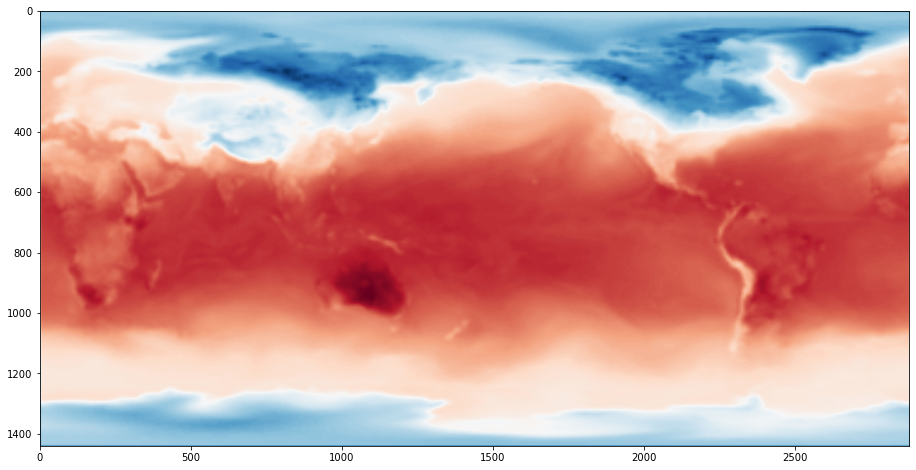

In [91]:
%matplotlib inline
# 하루치 기온을 봅시다
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(16, 8))
plt.imshow(dsets[0][::4, ::4], cmap='RdBu_r');

청크 크기가`(500, 500)`인 `da.from_array` 함수를 사용하여 `h5py.Dataset` 객체 리스트에서 `dask.array` 객체 목록을 만듭니다

In [92]:
arrays = [da.from_array(dset, chunks=(500, 500)) for dset in dsets]
arrays[0:4]

[dask.array<array, shape=(5760, 11520), dtype=float64, chunksize=(500, 500), chunktype=numpy.ndarray>,
 dask.array<array, shape=(5760, 11520), dtype=float64, chunksize=(500, 500), chunktype=numpy.ndarray>,
 dask.array<array, shape=(5760, 11520), dtype=float64, chunksize=(500, 500), chunktype=numpy.ndarray>,
 dask.array<array, shape=(5760, 11520), dtype=float64, chunksize=(500, 500), chunktype=numpy.ndarray>]

이`dask.array` 객체 목록을`da.stack`을 사용하여 단일`dask.array` 객체에 스택합니다.

이렇게 하면 결과 배열은 (31, 5760, 11520) shape의 array가 됩니다.

In [94]:
x = da.stack(arrays, axis=0)
x

,Array,Chunk
Bytes,16.46 GB,2.00 MB
Shape,"(31, 5760, 11520)","(1, 500, 500)"
Count,17887 Tasks,8928 Chunks
Type,float64,numpy.ndarray


시간축을 따라이 배열의 평균을 그려봅시다

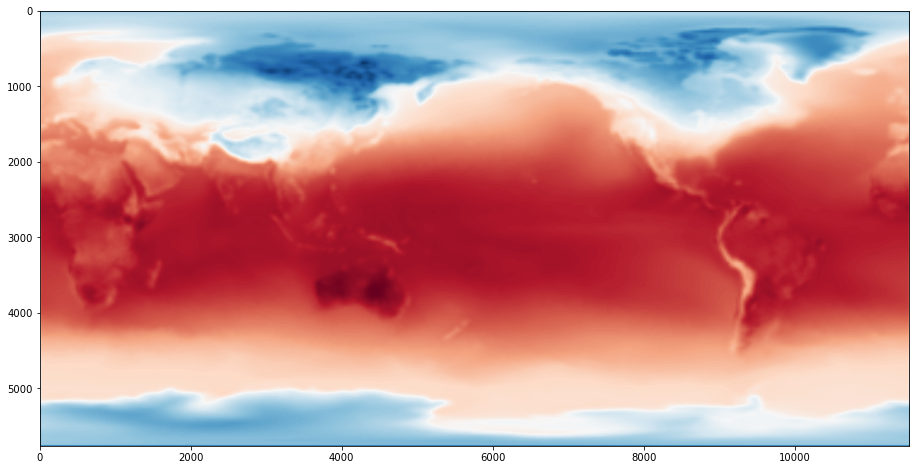

In [95]:
result = x.mean(axis=0)
fig = plt.figure(figsize=(16, 8))
plt.imshow(result, cmap='RdBu_r');

첫날과 평균의 차이를 그려봅시다.

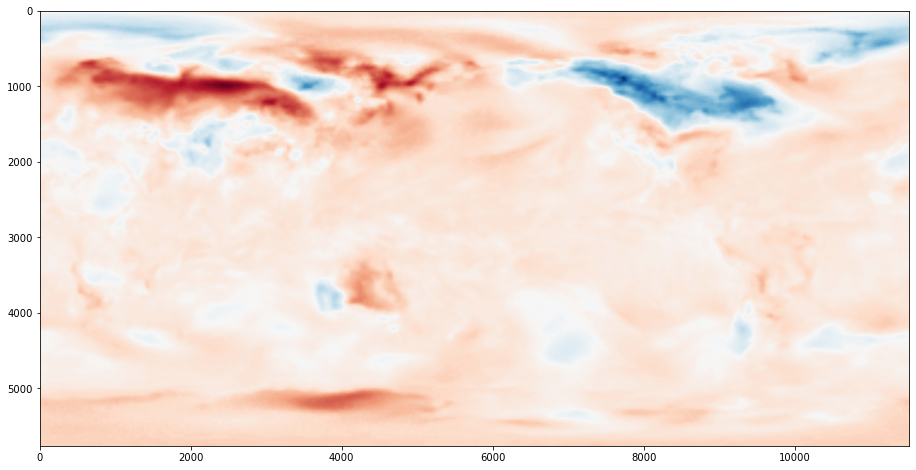

In [96]:
result = x[0] - x.mean(axis=0)
fig = plt.figure(figsize=(16, 8))
plt.imshow(result, cmap='RdBu_r');

## Example: Lennard-Jones potential

The [Lennard-Jones potential](https://en.wikipedia.org/wiki/Lennard-Jones_potential) is used in particle simulations in physics, chemistry and engineering. It is highly parallelizable.

$V(r)= 4 \epsilon \left [ {\left (\dfrac{\sigma}{r} \right )}^{12}-{\left (\dfrac{\sigma}{r} \right )}^{6} \right] \label{1}$

<img src = "Figs/LJpotential.png">

일단 7천개의 입자를 numpy로 시뮬레이션 해 봅시다.

In [97]:
import numpy as np

# make a random collection of particles
def make_cluster(natoms, radius=40, seed=1981):
    np.random.seed(seed)
    cluster = np.random.normal(0, radius, (natoms,3))-0.5
    return cluster

def lj(r2):
    sr6 = (1./r2)**3
    pot = 4.*(sr6*sr6 - sr6)
    return pot

# build the matrix of distances
def distances(cluster):
    diff = cluster[:, np.newaxis, :] - cluster[np.newaxis, :, :]
    mat = (diff*diff).sum(-1)
    return mat

# the lj function is evaluated over the upper traingle
# after removing distances near zero
def potential(cluster):
    d2 = distances(cluster)
    dtri = np.triu(d2)
    energy = lj(dtri[dtri > 1e-6]).sum()
    return energy

In [98]:
cluster = make_cluster(int(7e3), radius=500)

In [99]:
%time potential(cluster)

Wall time: 2.26 s


-0.21282893668845293

가장 시간이 많이 걸리는 함수는 `distance` 라는 것을 기억해 두세요.

In [100]:
%prun -s tottime potential(cluster)

### Dask version

다음은 Dask 버전입니다. Dask를 최대한 활용하려면 'portential'함수 만 다시 작성하면됩니다.

`da.nansum`은 병렬 효율성을 개선하기 위해 전체 $N \times N$ 거리 매트릭스를 구하는 데에 사용되었습니다.

In [101]:
import dask.array as da

# compute the potential on the entire
# matrix of distances and ignore division by zero
def potential_dask(cluster):
    d2 = distances(cluster)
    energy = da.nansum(lj(d2))/2.
    return energy

NumPy 배열을 Dask 배열로 변환 해 보겠습니다. 전체 NumPy 어레이가 메모리에 올라갈 정도로 작기 때문에 CPU 코어 수로 어레이를 나누는 것이 계산적으로 더 효율적일 것 같습니다.

In [102]:
from os import cpu_count
print(f"cpu count: {cpu_count()}")
dcluster = da.from_array(cluster, chunks=cluster.shape[0]//cpu_count())

cpu count: 32


이제 실제로 계산해 봅시다

In [103]:
e = potential_dask(dcluster)
%time e.compute()

C:\anaconda\anaconda3\envs\dask-tutorial\lib\site-packages\dask\array\core.py:3949: PerformanceWarning: Increasing number of chunks by factor of 33
  result = blockwise(


Wall time: 1.74 s


-0.21282893668845304

생각보다 큰 차이는 안 나네요. 아마 7천개 particle은 32개 코어에 나누기는 수가 너무 적기 때문인 것 같습니다.

In [104]:
from os import cpu_count
print(f"cpu count: {cpu_count()}")
dcluster2 = da.from_array(cluster, chunks=cluster.shape[0]//4)
e2 = potential_dask(dcluster2)
%time e2.compute()

cpu count: 32
Wall time: 959 ms


-0.21282893668845307

Limitations
-----------

Dask Array는 전체 numpy 인터페이스를 구현하지 않습니다. 이것을 기대하는 사용자 실망 할 것입니다. 특히 Dask Array에는 다음과 같은 오류가 있습니다.
1. Dask는``np.linalg``를 모두 구현하지 않습니다. 이것은 이미 병렬화된 BLAS / LAPACK으로 구현되어 있긴 합니다. 과학 연구에는 꽤 많이 사용하는데, dask는 이것을 다 슬수는 없습니다.

2. Dask Array는 결과 모양이 배열의 값에 따라 달라지는 일부 연산을 지원하지 않습니다 (예 : Dask Array 하나를 다른 Boolean 마스크로 마스킹). 이런 경우 마스크의 청크 크기를 알 수 없으므로 청크 크기를 알아야하는 다른 작업에 문제가 발생할 수 있습니다.

3. Dask Array는 병렬로 수행하기가 매우 어렵고 매우 큰 데이터에서 큰 필요가 없는 sort를 구현하지 않았습니다. 데이터가 매우 크면 보통은 상위 혹은 하위 데이터 몇개를 보는 것이 더 많이 사용괴디 때문에, ``topk``와 같은 병렬 친화적인 대안을 구현해 두긴 했습니다. 

4. Dask 개발은 많은 사람이 쓰는 것 부터 구현됩니다. 덜 사용되는 기능은 보통 구현되지 않거나 늦게 구현됩니다. 오픈소스와 커뮤니티 개발의 특성이기도 합니다.

In [105]:
client.close()

# Dask DataFrames

우리는 앞에서 `dask.delayed`를 사용하여 CSV 파일 디렉토리에 병렬 데이터 프레임 계산을 구현했습니다. 이 섹션에서는 table형식 계산의 일반적인 경우에 대해 'dask.dataframe'을 사용하여 유사한 계산을 자동으로 구현하는 것을 배웁니다. Dask 데이터 프레임은 Pandas 데이터 프레임처럼 보이고 느껴지지만 'dask.delayed'를 지원하는 동일한 인프라에서 실행됩니다.

이 챕터에서는 이전과 동일한 뉴욕 공항 데이터를 사용하지만 이제 for 루프를 작성하는 대신`dask.dataframe`이 계산을 수행하도록 합시다. `dask.dataframe.read_csv` 함수는 `"data/nycflights/*. csv"`와 같은 globstring을 가져 와서 모든 데이터에 대해 한 번에 병렬 계산을 작성할 수 있습니다.

##`dask.dataframe`을 사용하는 경우

Pandas는 메모리에 맞는 테이블 형식 데이터 세트에 적합합니다. Dask는 분석하려는 데이터 세트가 컴퓨터의 RAM보다 클 때 유용합니다. 우리가 작업중인 데모 데이터 세트는 약 200MB에 불과하므로 꼭 쓰지 않아도 되지만, 이보다 큰 데이터라면 `dask.dataframe`을 사용할 수 있습니다

`dask.dataframe` 모듈은 Pandas `DataFrame` API를 모방하는 병렬 block `DataFrame` 객체를 구현합니다. 하나의 Dask `DataFrame`은 인덱스를 따라 분리 된 많은 인 메모리 Pandas `DataFrames`으로 구성됩니다. Dask`DataFrame`에 대한 하나의 작업은 병렬성과 메모리 제약을 염두에두고 구성되는 Pandas `DataFrame`에 대한 다수의 Pandas operation을 구성하게 합니다.

효율적인 실행을 위해 데이터 프레임 분할이 중요하다는 것을 미리 기억해 둡시다.

## Create data

In [106]:
%run prep.py -d flights

<Figure size 432x288 with 0 Axes>

## Setup

In [107]:
from dask.distributed import Client

client = Client(n_workers=4)

artificial data를 만들어봅시다.

In [108]:
from prep import accounts_csvs
accounts_csvs()

import os
import dask
filename = os.path.join('data', 'accounts.*.csv')
filename

'data\\accounts.*.csv'

파일 이름에는 glob 패턴 `*`가 포함되어 있으므로 해당 패턴과 일치하는 경로의 모든 파일은 동일한 Dask DataFrame으로 읽혀집니다.

In [109]:
import dask.dataframe as dd
df = dd.read_csv(filename)
df.head()

,id,names,amount
0,235,Yvonne,4
1,199,Oliver,5652
2,315,Oliver,552
3,7,Xavier,152
4,452,Alice,2260


In [110]:
# load and count number of rows
len(df)

3000000

어떤 식으로 위의 계산이 작동하는 것일까요?

- Dask는 입력 경로를 조사한 결과 일치하는 파일이 세 개 있음을 발견했습니다.
- 각 청크에 대해 일련의 작업이 자동으로 생성됩니다. 이 경우 원본 CSV 파일 당 하나씩 생성됩니다.
- 각 파일은 Pandas DataFrame 객체로 로드되고, `len()`을 수행합니다.
- 각 값들이 더해져서 최종 총합계를 제공합니다.

### Real Data

뉴욕시 지역의 3개 공항 데이터를 다시 써 봅시다.

In [111]:
df = dd.read_csv(os.path.join('data', 'nycflights', '*.csv'),
                 parse_dates={'Date': [0, 1, 2]})

지금의 데이터 프레임에는 데이터가 포함되어 있지 않습니다. Dask는 첫 번째 파일의 시작 부분을 읽고 열 이름과 dtype만 추론한 상태입니다.

In [112]:
df

,Date,DayOfWeek,DepTime,CRSDepTime,ArrTime,CRSArrTime,UniqueCarrier,FlightNum,TailNum,ActualElapsedTime,CRSElapsedTime,AirTime,ArrDelay,DepDelay,Origin,Dest,Distance,TaxiIn,TaxiOut,Cancelled,Diverted
npartitions=10,,,,,,,,,,,,,,,,,,,,,
,datetime64[ns],int64,float64,int64,float64,int64,object,int64,float64,float64,int64,float64,float64,float64,object,object,float64,float64,float64,int64,int64
,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...


We can view the start and end of the data

In [113]:
df.head() # 이건 작동합니다.

,Date,DayOfWeek,DepTime,CRSDepTime,ArrTime,CRSArrTime,UniqueCarrier,FlightNum,TailNum,ActualElapsedTime,...,AirTime,ArrDelay,DepDelay,Origin,Dest,Distance,TaxiIn,TaxiOut,Cancelled,Diverted
0,1990-01-01,1,1621.0,1540,1747.0,1701,US,33,NaN,86.0,...,NaN,46.0,41.0,EWR,PIT,319.0,NaN,NaN,0,0
1,1990-01-02,2,1547.0,1540,1700.0,1701,US,33,NaN,73.0,...,NaN,-1.0,7.0,EWR,PIT,319.0,NaN,NaN,0,0
2,1990-01-03,3,1546.0,1540,1710.0,1701,US,33,NaN,84.0,...,NaN,9.0,6.0,EWR,PIT,319.0,NaN,NaN,0,0
3,1990-01-04,4,1542.0,1540,1710.0,1701,US,33,NaN,88.0,...,NaN,9.0,2.0,EWR,PIT,319.0,NaN,NaN,0,0
4,1990-01-05,5,1549.0,1540,1706.0,1701,US,33,NaN,77.0,...,NaN,5.0,9.0,EWR,PIT,319.0,NaN,NaN,0,0


In [114]:
df.tail()  # 이 작업은 실패합니다.

ValueError: Mismatched dtypes found in `pd.read_csv`/`pd.read_table`.

+----------------+---------+----------+
| Column         | Found   | Expected |
+----------------+---------+----------+
| CRSElapsedTime | float64 | int64    |
| TailNum        | object  | float64  |
+----------------+---------+----------+

The following columns also raised exceptions on conversion:

- TailNum
  ValueError("could not convert string to float: 'N54711'")

Usually this is due to dask's dtype inference failing, and
*may* be fixed by specifying dtypes manually by adding:

dtype={'CRSElapsedTime': 'float64',
       'TailNum': 'object'}

to the call to `read_csv`/`read_table`.

### 왜 이렇게 되나요?

데이터 유형을 추론하기 전에 전체 파일을 읽는 `pandas.read_csv`와 달리 `dask.dataframe.read_csv`는 파일의 시작 부분 (또는 glob을 사용하는 경우 첫 번째 파일)에서 아주 작은 샘플만 읽어옵니다. 이러한 추론 된 데이터 타입을 모든 파티션을 읽을 때 사용합니다.

이 경우 샘플에서 유추 된 데이터 유형이 올바르지 않습니다. 첫 번째`n` 행에는 `CRSElapsedTime` (pandas가 `float`로 추론)에 대한 값이 없으며 나중에 문자열 (`object` dtype)이됩니다. Dask는 이러한 경우 오류를 보여줍니다. 이 경우 해결하기 위한 몇 가지 옵션이 있습니다.

- `dtype` 키워드를 사용하여 직접 dtype을 지정합니다. 이 방법은 오류가 가장 적고 가장 성능이 뛰어나므로 권장되는 솔루션입니다.
-`sample` 키워드의 크기(바이트)를 늘리면 됩니다.
- `assume_missing`을 사용하여 `dask`가 `int`(누락 된 값을 허용하지 않음)로 추론 된 열이 실제로 부동 소수점(누락 된 값을 허용 함)이라고 가정하도록합니다. 다만 우리의 경우에는 string이므로 이 방법이 작동하지 않습니다.

이 경우 첫 번째 옵션을 사용하고 문제가되는 열의 'dtypes'를 직접 지정합니다.

In [115]:
df = dd.read_csv(os.path.join('data', 'nycflights', '*.csv'),
                 parse_dates={'Date': [0, 1, 2]},
                 dtype={'TailNum': str,
                        'CRSElapsedTime': float,
                        'Cancelled': bool}) 

In [116]:
df.tail()  # now works

,Date,DayOfWeek,DepTime,CRSDepTime,ArrTime,CRSArrTime,UniqueCarrier,FlightNum,TailNum,ActualElapsedTime,...,AirTime,ArrDelay,DepDelay,Origin,Dest,Distance,TaxiIn,TaxiOut,Cancelled,Diverted
269176,1999-12-27,1,1645.0,1645,1830.0,1901,UA,1753,N516UA,225.0,...,205.0,-31.0,0.0,LGA,DEN,1619.0,7.0,13.0,False,0
269177,1999-12-28,2,1726.0,1645,1928.0,1901,UA,1753,N504UA,242.0,...,214.0,27.0,41.0,LGA,DEN,1619.0,5.0,23.0,False,0
269178,1999-12-29,3,1646.0,1645,1846.0,1901,UA,1753,N592UA,240.0,...,220.0,-15.0,1.0,LGA,DEN,1619.0,5.0,15.0,False,0
269179,1999-12-30,4,1651.0,1645,1908.0,1901,UA,1753,N575UA,257.0,...,233.0,7.0,6.0,LGA,DEN,1619.0,5.0,19.0,False,0
269180,1999-12-31,5,1642.0,1645,1851.0,1901,UA,1753,N539UA,249.0,...,232.0,-10.0,-3.0,LGA,DEN,1619.0,6.0,11.0,False,0


## Computations with `dask.dataframe`

`DepDelay` 열의 최대 값을 계산합니다. Pandas만으로 구현하려면 어떻게 하면 될까요? 각 파일을 반복하여 파일별 최대 값을 찾은 다음 모든 개별 최대 값에 대한 최종 최대 값을 찾습니다.

```python
maxes = []
for fn in filenames:
    df = pd.read_csv(fn)
    maxes.append(df.DepDelay.max())
    
final_max = max(maxes)
```

병렬로 실행되도록`pd.read_csv`를 `dask.delayed`로 래핑 할 수 있습니다. 그럼에도 불구하고 우리는 여전히 루프, 중간 결과 (파일 당 하나)및 최종 결과값(중간 최대 값의 '최대')에 대해 생각해야합니다. 사실 중간값들은 없어도 되는 것들이죠

```python
df = pd.read_csv(filename, dtype=dtype)
df.DepDelay.max()
```

`dask.dataframe`을 사용하면 병렬로 작동하는 pandas와 유사한 코드를 작성할 수 있습니다.

In [117]:
%time df.DepDelay.max().compute()

Wall time: 1.27 s


1435.0

이것은 우리를 위해 지연된 계산 순서를 구한 다음 나중에 실행합니다.

참고할 사항 :

1.`dask.delayed`와 마찬가지로 작업이 끝나면`.compute()`를 호출해야합니다. 이 시점까지 실제로 계산되지 않습니다.

2. Dask는 가능한 한 빨리 중간 결과 (예 : 각 파일의 전체 pandas 데이터 프레임)을 삭제합니다.
  - 이를 통해 메모리보다 큰 데이터를 처리할 수 있습니다.
  - 이것은 반복 된 계산이 매번 모든 데이터를 다시 로드해야 한다는 것을 의미합니다.
    
`Delayed` 객체와 마찬가지로`.visualize` 메소드를 사용하여 기본 작업 그래프를 볼 수 있습니다.

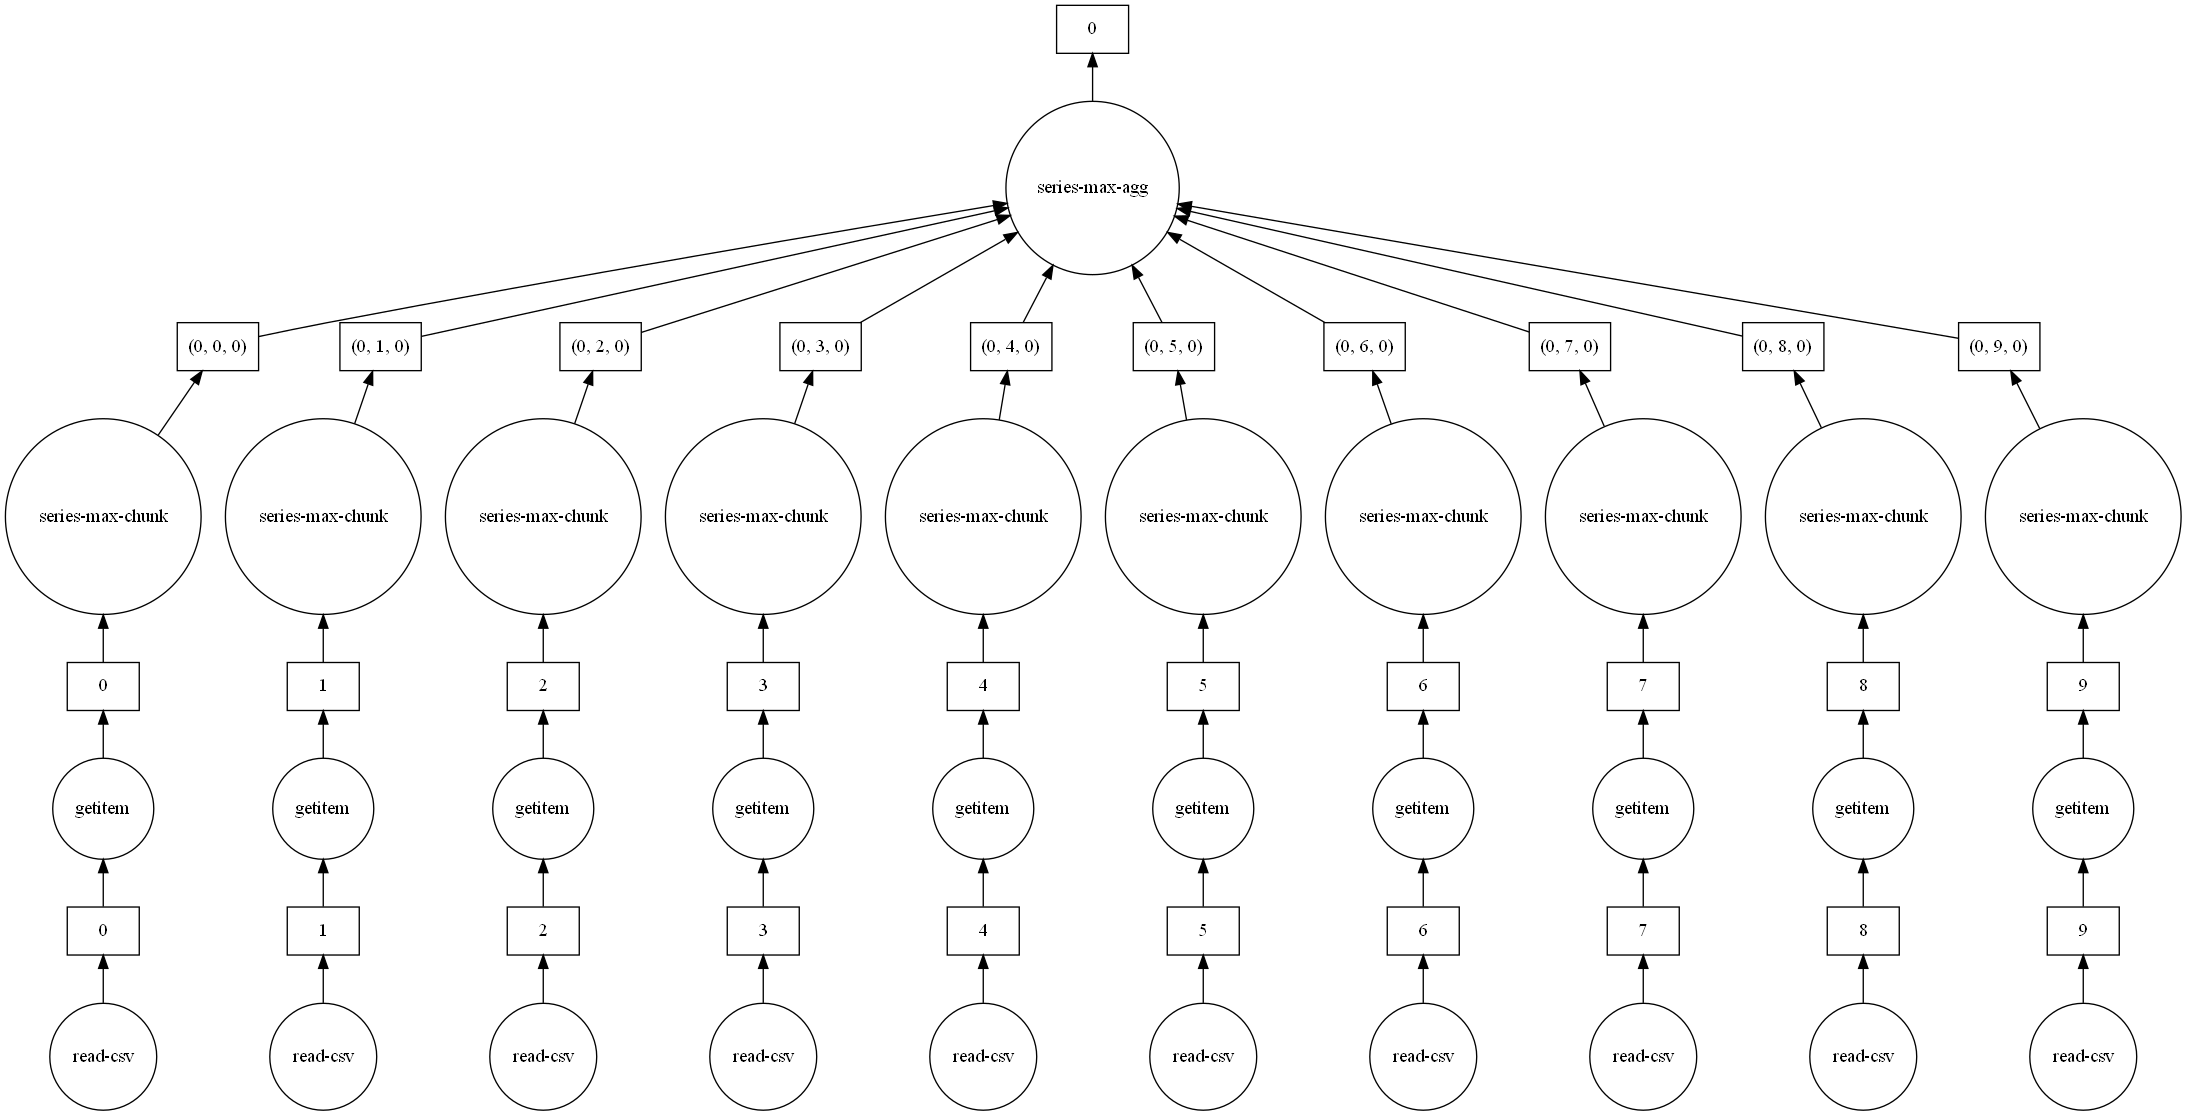

In [118]:
# notice the parallelism
df.DepDelay.max().visualize()

## Exercises

이 섹션에서는 몇 가지 `dask.dataframe` 계산을 해 봅시다. Pandas에 익숙하다면 이것들이 어렵지는 않습니다. 다만 언제`compute`를 호출해야 하는지 생각해야합니다.

### 데이터에 몇개의 행이 있습니까?

In [119]:
len(df)

2611892

### 이 중 취소되지 않은 비행은 몇 건인가요?

In [120]:
len(df[~df.Cancelled])

2540961

### 각 공항마다 취소되지 않은 비행은 몇 건인가요?

In [121]:
df[~df.Cancelled].groupby('Origin').Origin.count().compute()

Origin
EWR    1139451
JFK     427243
LGA     974267
Name: Origin, dtype: int64

### 공항마다 평균 지연 시간은 몇 분인가요?

In [122]:
df.groupby("Origin").DepDelay.mean().compute()

Origin
EWR    10.295469
JFK    10.351299
LGA     7.431142
Name: DepDelay, dtype: float64

### 평균적으로 가장 지연을 많이 시킨 요일은 언제인가요?

In [123]:
df.groupby("DayOfWeek").DepDelay.mean().compute()

DayOfWeek
1     8.096565
2     8.149109
3     9.141912
4    10.538275
5    11.476687
6     7.824071
7     8.994296
Name: DepDelay, dtype: float64

## Sharing Intermediate Results

위의 모든 것을 계산할 때 동일한 작업을 두 번 이상 수행하는 경우가 있습니다. 이러한 비효율성을 줄이기 위해서 `dask.dataframe`은 인수를 해시하여 중복 계산을 공유하고 한 번만 계산할 수 있도록합니다.

예를 들어 취소되지 않은 모든 항공편의 출발 지연에 대한 평균 및 표준 편차를 계산할 수 있습니다. dask dataframe은 lazy execution을 수행하므로 이러한 값은 아직 최종 결과가 아닙니다. 결과를 얻는 데 필요한 순서를 구해 둘 뿐입니다. 

두 번의 계산 호출로 계산하면 중간 계산이 공유되지 않습니다.

In [124]:
non_cancelled = df[~df.Cancelled]
mean_delay = non_cancelled.DepDelay.mean()
std_delay = non_cancelled.DepDelay.std()

In [125]:
%%time

mean_delay_res = mean_delay.compute()
std_delay_res = std_delay.compute()

Wall time: 2.08 s


하지만 한 번의 compute 를 통해 계산하면 계산이 공유됩니다.

In [126]:
%%time

mean_delay_res, std_delay_res = dask.compute(mean_delay, std_delay)

Wall time: 1 s


'dask.compute'를 사용하는 데 걸리는 시간은 약 1/2입니다. 이는 'dask.compute'를 호출 할 때 두 결과에 대한 작업 그래프가 병합되어 공유 작업을 두 번이 아닌 한 번만 수행 할 수 있기 때문입니다. 특히`dask.compute`를 사용하면 다음 작업이 한 번만 수행됩니다.

- `read_csv` 호출
- 필터 (`df [~ df.Cancelled]`)
- 필요한 일부 계산 (`sum`,`count`)

여러 결과 사이의 병합 된 작업 그래프가 어떻게 보이는지 확인하려면 `dask.visualize` 함수를 사용할 수 있습니다.

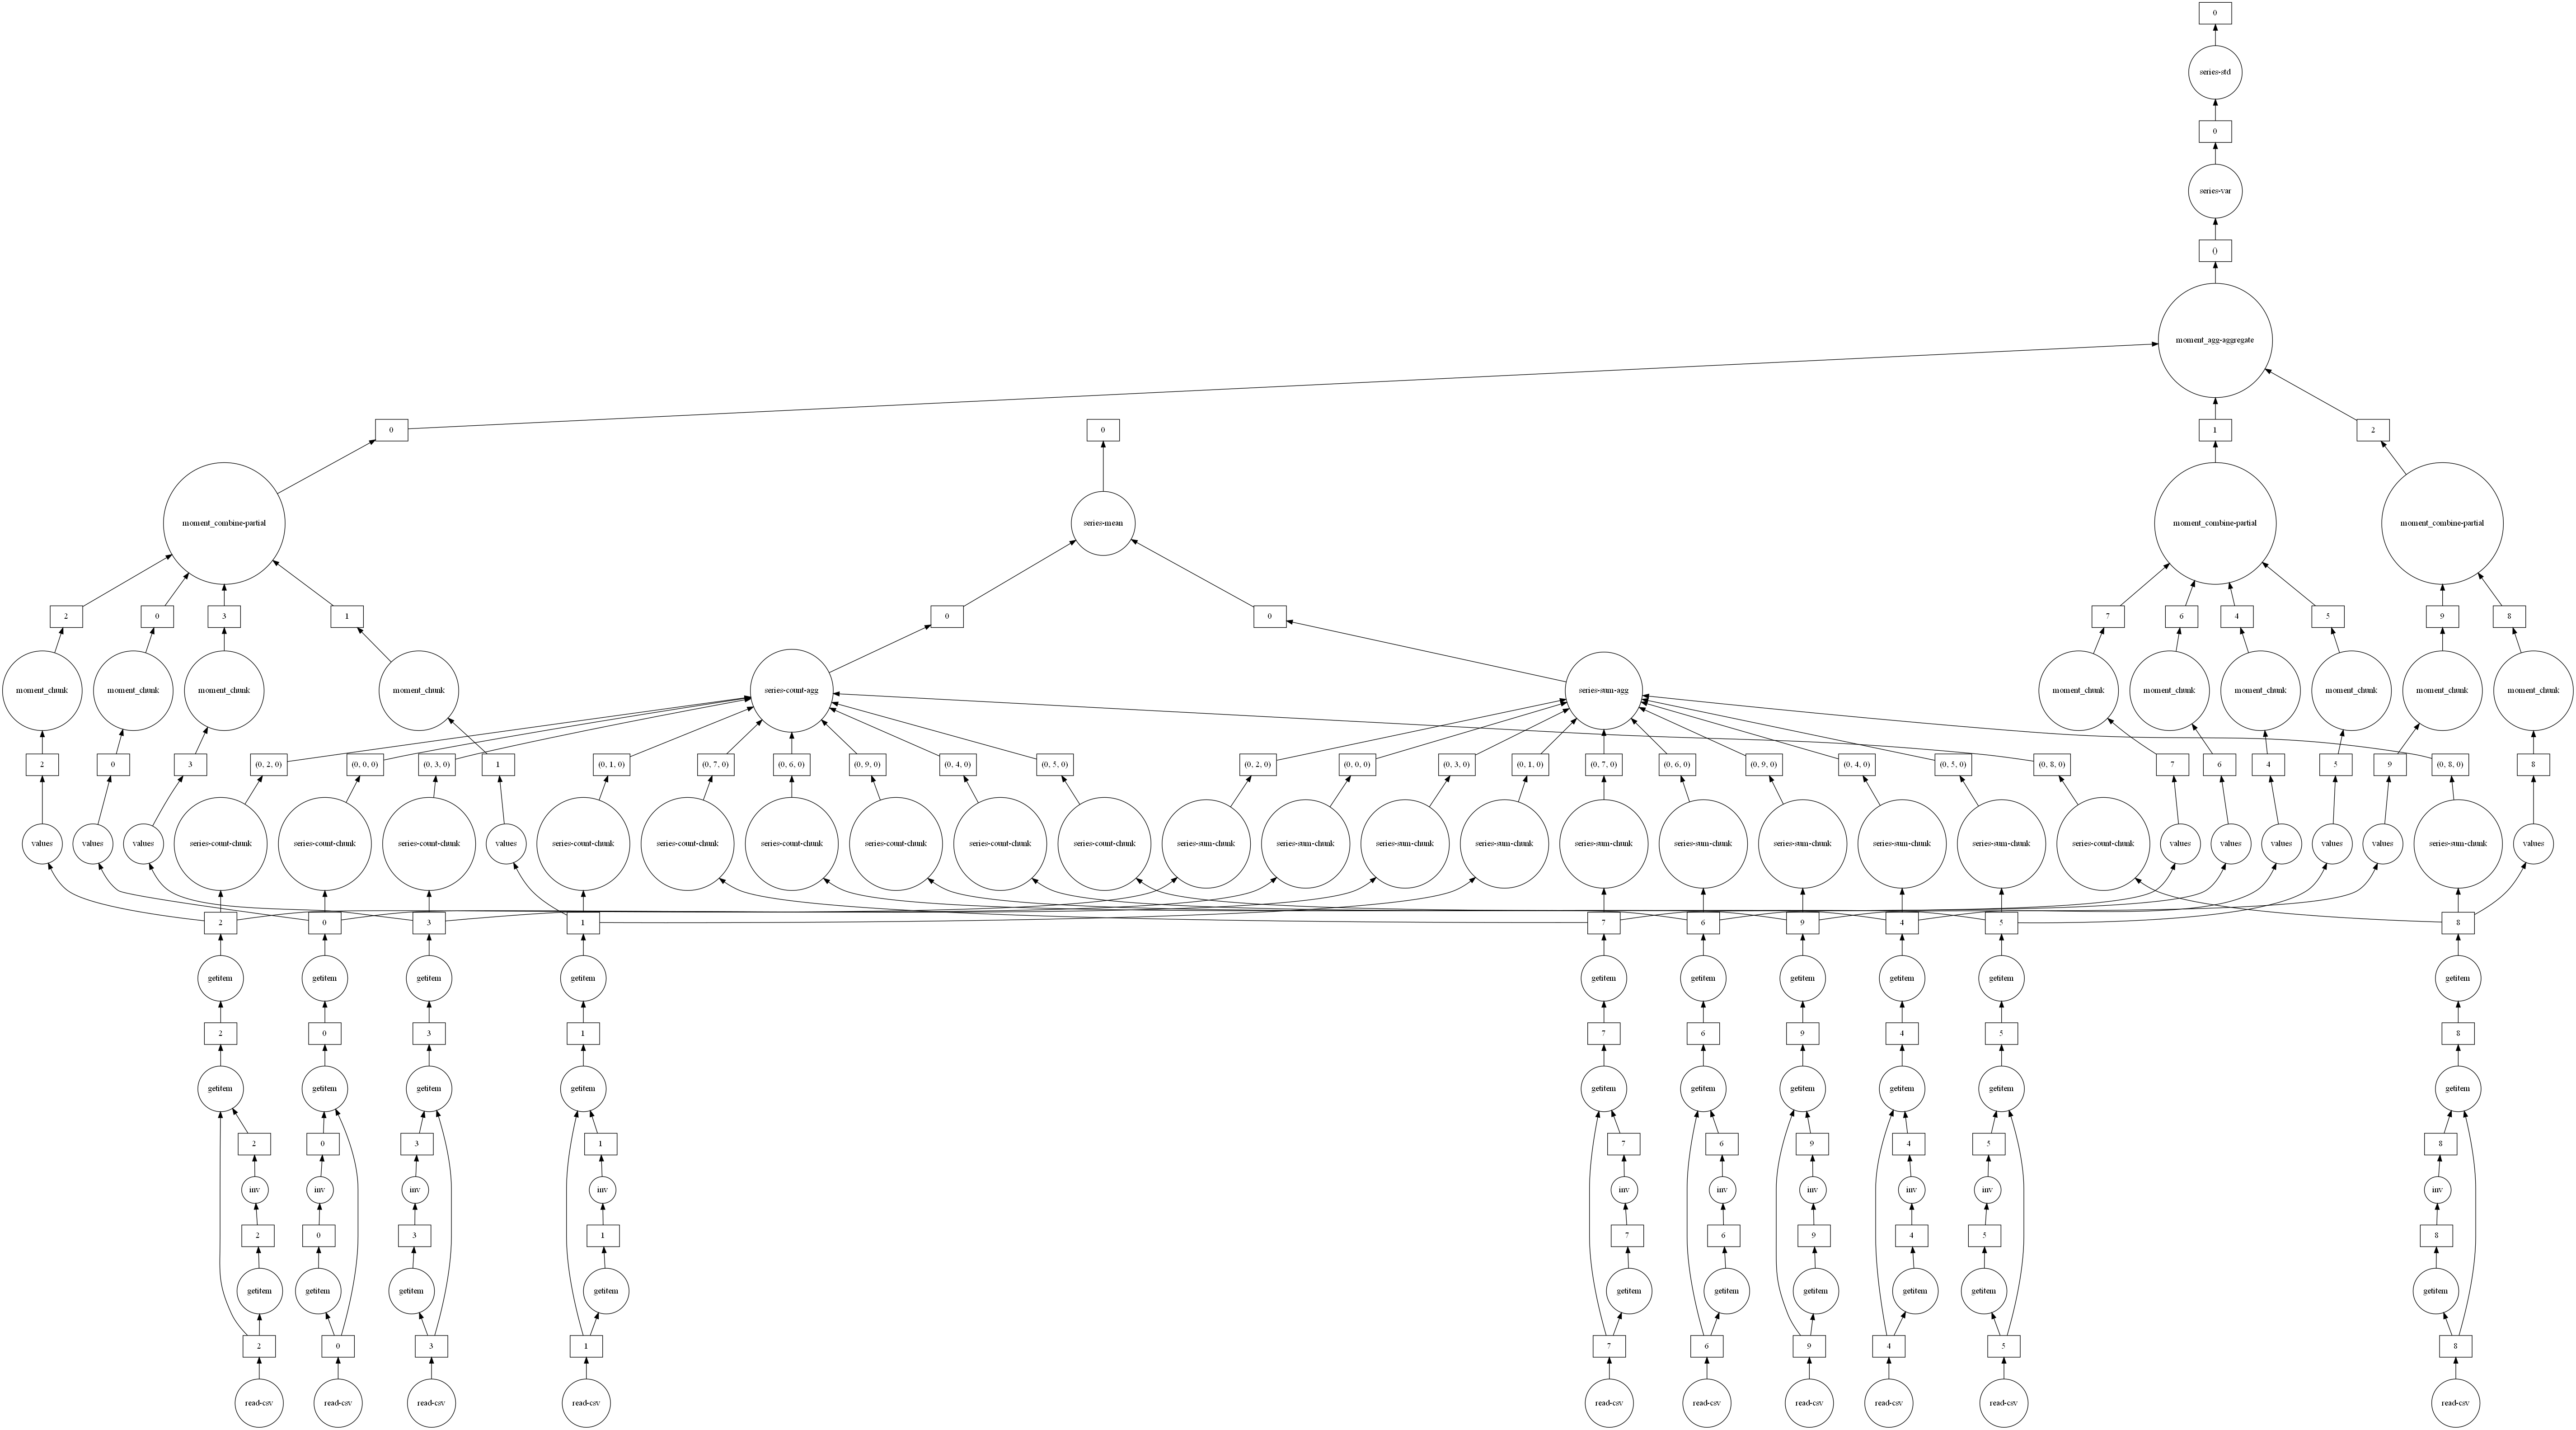

In [127]:
dask.visualize(mean_delay, std_delay)

## How does this compare to Pandas?

Pandas는 `dask.dataframe`보다 기능이 더 많습니다. 데이터가 메모리에 올라갈 수 있다면 Pandas를 사용해야합니다. `dask.dataframe` 모듈은 메모리에 적재될 수 없는 크기의 데이터를 `pandas`의 일부 기능을 구현하여 사용하게 해 줍니다.

예를 들어서 예제 데이터는 디스크에서 45MB이며 메모리에서 400MB를 사용합니다. 이 데이터는 최근 나오는 컴퓨터에서는 일반적으로 Pandas를 사용할만큼 충분히 작습니다. 

Dask.dataframe은 Pandas가 MemoryError:를 낼 떄에 의미가 있습니다.


    
또한 분산 스케줄러를 사용하면 클러스터 전체에서 동일한 데이터 프레임 표현식을 실행할 수 있습니다. 대규모 "빅데이터"처리를 가능하게하기 위해 `read_csv`와 같은 데이터 수집 기능을 실행할 수 있습니다. 일반적으로 데이터는 모든 작업자 노드 (예: amazon의 S3)에 액세스 할 수있는 공유 스토리지에 보관되며 대부분의 작업은 일부 열만 선택하여 시작되기 때문입니다. 예를 들어 데이터를 변환하고 필터링하는 경우 상대적으로 적은 양의 데이터 만 시스템간에 통신하면됩니다.

Dask.dataframe 작업은 내부적으로 'pandas'작업을 사용합니다. 일반적으로 다음 두 가지 경우를 제외하고 거의 동일한 속도로 실행됩니다.

1. Dask는 작업 당 약 1ms의 약간의 오버 헤드를 발생시킵니다. 일반적으로 무시할 수 있습니다.
2. Pandas가 GIL을 release하는 경우 'dask.dataframe' 프로세스 내에서 여러 개의 Pandas 작업을 병렬로 호출하여 코어 수에 다소 비례하여 속도를 높일 수 있습니다. GIL을 release하지 않는 연산의 경우 동일한 속도 향상을 위해 여러 프로세스가 필요합니다.

## Dask DataFrame Data Model

대부분의 경우 Dask DataFrame은 pandas DataFrame처럼 느껴집니다. 지금까지 우리가 본 가장 큰 차이점은 Dask 작업이 lazy execution이 가능하다는 것입니다. 그들은 즉시 실행하는 대신 작업 그래프를 작성합니다. 이를 통해 Dask는 병렬연산 혹은 다중연산을 할 수 있습니다.

위의 Array 파트에서 'dask.array'가 하나 이상의 차원을 따라 나누어진 다수의 NumPy 배열로 구성되어 있음을 확인했습니다. 'dask.dataframe'도 이와 유사합니다. Dask DataFrame은 많은 Pandas DataFrame으로 구성됩니다. `dask.dataframe`의 경우 청킹은 인덱스를 따라서 수행됩니다.

<img src="http://dask.pydata.org/en/latest/_images/dask-dataframe.svg" width="28%">

## Converting `CRSDepTime` to a timestamp

공항 데이터에서 `CRSDepTime` column은 timestamp를 `HHMM`으로 저장하며 `read_csv`에서 정수로 읽습니다.

In [128]:
crs_dep_time = df.CRSDepTime.head(10)
crs_dep_time

0    1540
1    1540
2    1540
3    1540
4    1540
5    1540
6    1540
7    1540
8    1540
9    1540
Name: CRSDepTime, dtype: int64

이를 예정된 출발 시간의 타임 스탬프로 변환하려면 이 정수를`pd.Timedelta` 객체로 변환 한 다음 `Date` 열과 결합해야합니다.

Pandas에서는 `pd.to_timedelta` 함수와 약간의 계산을 통해 가능합니다.

In [129]:
import pandas as pd

# Get the first 10 dates to complement our `crs_dep_time`
date = df.Date.head(10)

# Get hours as an integer, convert to a timedelta
hours = crs_dep_time // 100
hours_timedelta = pd.to_timedelta(hours, unit='h')

# Get minutes as an integer, convert to a timedelta
minutes = crs_dep_time % 100
minutes_timedelta = pd.to_timedelta(minutes, unit='m')

# Apply the timedeltas to offset the dates by the departure time
departure_timestamp = date + hours_timedelta + minutes_timedelta
departure_timestamp

0   1990-01-01 15:40:00
1   1990-01-02 15:40:00
2   1990-01-03 15:40:00
3   1990-01-04 15:40:00
4   1990-01-05 15:40:00
5   1990-01-06 15:40:00
6   1990-01-07 15:40:00
7   1990-01-08 15:40:00
8   1990-01-09 15:40:00
9   1990-01-10 15:40:00
dtype: datetime64[ns]

### Custom code and Dask Dataframe

원래는 `pd.to_timedelta`를 `dd.to_timedelta`로 바꾸고 전체 dask DataFrame에서 동일한 일을 할 수 있습니다. 

그러나 연습을 위해 Dask가 Dask DataFrames에서 작동하는 `dd.to_timedelta`를 구현하지 않았다고 가정해 보겠습니다. 

`to_timedelta`를 자체적으로 구현하는 데 사용할 수있는 `map_partitions`을 써 봅시다.

In [ ]:
# Look at the docs for `map_partitions`
# help(df.CRSDepTime.map_partitions)

기본 아이디어는 DataFrame에서 작동하는 함수를 각 파티션에 적용하는 것입니다. 이 경우 `pd.to_timedelta`를 적용합니다.

In [130]:
hours = df.CRSDepTime // 100
# hours_timedelta = pd.to_timedelta(hours, unit='h')
hours_timedelta = hours.map_partitions(pd.to_timedelta, unit='h')

minutes = df.CRSDepTime % 100
# minutes_timedelta = pd.to_timedelta(minutes, unit='m')
minutes_timedelta = minutes.map_partitions(pd.to_timedelta, unit='m')

departure_timestamp = df.Date + hours_timedelta + minutes_timedelta

In [131]:
departure_timestamp

Dask Series Structure:
npartitions=10
    datetime64[ns]
               ...
         ...      
               ...
               ...
dtype: datetime64[ns]
Dask Name: add, 90 tasks

In [132]:
%time departure_timestamp.head()

Wall time: 405 ms


0   1990-01-01 15:40:00
1   1990-01-02 15:40:00
2   1990-01-03 15:40:00
3   1990-01-04 15:40:00
4   1990-01-05 15:40:00
dtype: datetime64[ns]

### Exercise
`map_partitions`에 대한 단일 호출을 사용하도록 위를 다시 구현하겠습니다. 이것은 그래프의 작업 수를 줄이므로 두 개의 개별 호출보다 약간 더 효율적입니다.

In [133]:
def compute_departure_timestamp(df):
    hours = df.CRSDepTime // 100
    hours_timedelta = pd.to_timedelta(hours, unit='h')

    minutes = df.CRSDepTime % 100
    minutes_timedelta = pd.to_timedelta(minutes, unit='m')

    return df.Date + hours_timedelta + minutes_timedelta

departure_timestamp = df.map_partitions(compute_departure_timestamp)
%time departure_timestamp.head()

Wall time: 402 ms


0   1990-01-01 15:40:00
1   1990-01-02 15:40:00
2   1990-01-03 15:40:00
3   1990-01-04 15:40:00
4   1990-01-05 15:40:00
dtype: datetime64[ns]

## Limitations

Dask.dataframe은 Pandas API의 작지만 잘 사용되는 부분만 구현되어 있습니다. 이 제한은 두 가지 이유 때문입니다.

1. Pandas API는 매우 방대합니다.
2. 일부 작업은 실제로 병렬로 수행하기가 어렵습니다 (정렬이라던지..).

또한 ``set_index``와 같은 몇 가지 중요한 작업은 가능은 하지만 매우 느립니다. 데이터 셔플 링을 많이 수행하고 디스크 IO가 많기 때문입니다. 

In [ ]:
client.close()

# Today
- Dask란 무엇인가
- Dask를 통한 Lazy execution
- dask.bag
- dask.array
- dask.dataframe

# Next class
- NLP에서 자주 사용되는 Word2Vec에 대해서 배워봅시다
- Word2Vec에 자주 사용되는 Gensim 라이브러리를 사용해 봅시다.